In [503]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 2.1.1+cu121


In [504]:
import clip

clip.available_models()


/home/hoemam/anaconda3/envs/clip_prefix_caption/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [505]:
model, preprocess = clip.load("ViT-B/32")
model.eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [506]:
from pyexpat import features
import copy
import math
from sys import prefix
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import copy

from transformers import CLIPModel, AutoConfig, AutoModel

In [507]:
import os

import pandas as pd
import torch
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset
from transformers import CLIPTokenizer, CLIPProcessor, AutoTokenizer


class HatefulMemesDataset(Dataset):
    def __init__(self, root_folder, image_folder, feature_file,fairfacefile,entityfile,split='train', labels='original', image_size=224):
        super(HatefulMemesDataset, self).__init__()
        self.root_folder = root_folder
        self.image_folder = image_folder
        self.split = split
        self.labels = labels
        self.image_size = image_size
        self.info_file = f"{self.split}.csv"
        self.features_df = pd.read_csv(f"{self.split}_features.csv")
        self.fairface_df = pd.read_csv(f"{fairfacefile}.csv")
        self.entity_df = pd.read_csv(f"{entityfile}.csv")
        self.fairface_df=self.fairface_df[~self.fairface_df["face_name_align"].str.contains("race")]

        print("data here: ", self.info_file)
        self.df = pd.read_csv(self.info_file)
        # float_cols = self.df.select_dtypes(float).columns
        # self.df[float_cols] = self.df[float_cols].fillna(-1).astype('Int64')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        feature_row=self.features_df[self.features_df["id"]==row["id"]]
        entity_row = pd.DataFrame(self.entity_df[((self.entity_df["filename"].str.split(".").str[0]).astype(int)) == row["id"]])
        values = entity_row[["description1", "description2", "description3", "description4"]]
        entity_string = ','.join([x for x in values.iloc[0] if x != '' and pd.notna(x)])
        self.fairface_df["id"]=self.fairface_df["face_name_align"].str.split("/").str[-1].str.split("_").str[0]
        fairface_rows = self.fairface_df[(self.fairface_df["id"].astype(int) == row["id"])]
        fairface_string=''
        combined_strings=[]
        if len(fairface_rows)>0:
            for ff_row in fairface_rows.itertuples():
                combined_string = ', '.join([ff_row[2], ff_row[4], ff_row[5]])
                combined_strings.append(combined_string)
            fairface_string = '. '.join(combined_strings)
        item = {}
        image_fn = row['img'].split('/')[1]
        # print("faie:", fairface_string)
        # print("entities", entity_string)
        # print("caption", caption_string)
        # print("row text", row['text'])
        item['image'] = Image.open(f"{self.image_folder}/{image_fn}").convert('RGB').resize((self.image_size, self.image_size))
        item['text'] = row['text']+". "+fairface_string+". "+entity_string #remove fairface and entity strings to get baseline
        item['label'] = row['label']
        item['idx_meme'] = row['id']
        additional_features = feature_row.iloc[0, 2:].values.astype('float32')  # Convert to float32 for PyTorch compatibility
        item['additional_features'] = torch.tensor(additional_features)
        return item

In [508]:
class CustomCollator(object):

    def __init__(self):
        pre_trained_model = 'openai/clip-vit-large-patch14'
        self.image_processor = CLIPProcessor.from_pretrained(pre_trained_model)
        self.text_processor = CLIPTokenizer.from_pretrained(pre_trained_model)

    def __call__(self, batch):
        pixel_values = self.image_processor(images=[item['image'] for item in batch], return_tensors="pt")['pixel_values']
        text_output = self.text_processor([item['text'] for item in batch], padding=True, return_tensors="pt", truncation=True,max_length=77) #change max length from 77 if using larger model
        labels = torch.LongTensor([item['label'] for item in batch])
        idx_memes = torch.LongTensor([item['idx_meme'] for item in batch])
        additional_features=torch.stack([item['additional_features'] for item in batch])

        batch_new = {}
        batch_new['pixel_values'] = pixel_values,
        batch_new['input_ids'] = text_output['input_ids']
        batch_new['attention_mask'] = text_output['attention_mask']

        batch_new['labels'] = labels
        batch_new['idx_memes'] = idx_memes
        batch_new['additional_features']=additional_features
        return batch_new

collator = CustomCollator()

In [509]:
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores
multilingual_tokenizer_path = 'none'
fine_grained_labels = []
compute_fine_grained_metrics = True

# Load Datasets

In [510]:
labels = "original"
train_image_folder = './inpainted_images_train/inpainted_images_train/'
dev_image_folder = './inpainted_images_dev/inpainted_images_dev/'
test_image_folder = './inpainted_images_test/inpainted_images_test/'
image_folder = "../data/img/"
image_size = 224

dataset_train = HatefulMemesDataset(root_folder='data/', image_folder=image_folder, split='train',
            labels=labels, image_size=image_size)

dataset_val = HatefulMemesDataset(root_folder='data/', image_folder=image_folder, split='dev',
            labels=labels, image_size=image_size)

dataset_test = HatefulMemesDataset(root_folder='data/', image_folder=image_folder, split='test',
            labels=labels, image_size=image_size)

# uncomment this if you wanna use pre-processing steps on validation dataset 
# dataset_train = HatefulMemesDataset(root_folder='data/', image_folder=image_folder, feature_file='train_features.csv',fairfacefile='race_gender_age_all_10k',entityfile='entities_all_10k',split='train',
#             labels=labels, image_size=image_size)

# dataset_val = HatefulMemesDataset(root_folder='data/', image_folder=image_folder, feature_file='dev_features.csv',split='dev',
#             labels=labels, image_size=image_size)


data here:  train.csv
data here:  dev.csv
data here:  test.csv


In [511]:
#

In [512]:
for i in range(10):
    print(dataset_train[i])

{'image': <PIL.Image.Image image mode=RGB size=224x224 at 0x162D72021D0>, 'text': 'its their character not their color that matters. Black, Male, 30-39. Black, Male, 20-29. Facial hair,Forehead,Hair,Meter', 'label': 0, 'idx_meme': 42953, 'additional_features': tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])}
{'image': <PIL.Image.Image image mode=RGB size=224x224 at 0x162E62DD710>, 'text': "don't be afraid to love again everyone is not like your ex. Black, Male, 20-29. White, Female, 20-29. Bride,Photograph,Wedding,Wedding Dress", 'label': 0, 'idx_meme': 23058, 'additional_features': tensor([0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1.])}
{'image': <PIL.Image.Image image mode=RGB size=224x224 at 0x162DCDA3210>, 'text': 'putting bows on your pet. . Chartreux,Korat,Mammal,Cat-like', 'label': 0, 'idx_meme': 13894, 'additional_features': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}
{'image': <PIL.Image.Image image mode=

In [513]:
from torch.utils.data import DataLoader

dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=0, collate_fn=collator)
dataloader_val = DataLoader(dataset_val, batch_size=16, shuffle=False, num_workers=0, collate_fn=collator)
dataloader_test = DataLoader(dataset_test, batch_size=16, shuffle=False, num_workers=0, collate_fn=collator)



In [514]:
compute_fine_grained_metrics

True

In [515]:
dataloader_train

# Train The Model

In [516]:
class CLIPClassifier(pl.LightningModule):

    def __init__(self, args, fine_grained_labels, compute_fine_grained_metrics):
        super().__init__()

        # self.caption_mode = args.caption_mode
        self.use_pretrained_map = args['use_pretrained_map']
        self.num_mapping_layers = args['num_mapping_layers']
        self.map_dim = args['map_dim']
        self.fusion = args['fusion']
        self.num_pre_output_layers = args['num_pre_output_layers']
        self.lr = args['lr']
        self.weight_decay = args['weight_decay']
        self.weight_image_loss = args['weight_image_loss']
        self.weight_text_loss = args['weight_text_loss']
        self.weight_fine_grained_loss = args['weight_fine_grained_loss']
        self.weight_super_loss = args['weight_super_loss']
        self.fine_grained_labels = fine_grained_labels
        self.compute_fine_grained_metrics = compute_fine_grained_metrics

        self.acc = torchmetrics.Accuracy(task="binary")
        self.auroc = torchmetrics.AUROC(task="binary")
        # self.precision_score = torchmetrics.Precision()
        # self.recall = torchmetrics.Recall()
        # self.f1 = torchmetrics.F1Score()

        self.validation_step_outputs = []
        self.test_step_outputs = []

        self.clip = CLIPModel.from_pretrained(args['clip_pretrained_model'])
        self.image_encoder = copy.deepcopy(self.clip.vision_model)
        self.text_encoder = copy.deepcopy(self.clip.text_model)
        self.image_map = nn.Sequential(
                copy.deepcopy(self.clip.visual_projection),
                nn.ReLU(),
                nn.Linear(self.clip.projection_dim, self.map_dim)
                )
        self.text_map = nn.Sequential(
            copy.deepcopy(self.clip.text_projection),
            nn.ReLU(),
            nn.Linear(self.clip.projection_dim, self.map_dim)
            )


        

        if args['fusion'] in ['align', 'align_shuffle']:
            pre_output_input_dim = self.map_dim
        elif args['fusion'] == 'concat':
            pre_output_input_dim = self.map_dim*2
        elif args['fusion'].startswith('cross'):
            pre_output_input_dim = self.map_dim**2
        elif args['fusion'] == 'align_concat':
            pre_output_input_dim = self.map_dim*3
        elif args['fusion'] == 'attention_m':
            self.gen_query = nn.Linear(self.map_dim, self.map_dim//4)
            self.gen_key = nn.Linear(self.map_dim, self.map_dim//4)
            self.soft = nn.Softmax(dim=1)
            pre_output_input_dim = self.map_dim*2

        pre_output_layers = [nn.Dropout(p=args['drop_probs'])]
        self.additional_feature_size=16 #set to zero if using baseline
        pre_output_input_dim+=self.additional_feature_size


        if self.num_pre_output_layers >= 1: # first pre-output layer
            pre_output_layers.extend([nn.Linear(pre_output_input_dim, self.map_dim), nn.ReLU(), nn.Dropout(p=args['drop_probs'])])
            output_input_dim = self.map_dim
        for _ in range(1, self.num_pre_output_layers): # next pre-output layers
            pre_output_layers.extend([nn.Linear(self.map_dim, self.map_dim), nn.ReLU(), nn.Dropout(p=args['drop_probs'])])
        self.additional_feature_size=0 #set to zero if using baseline
        self.pre_output = nn.Sequential(*pre_output_layers)
        self.output = nn.Linear(output_input_dim+self.additional_feature_size, 1)
        self.output_image = nn.Linear(output_input_dim+self.additional_feature_size, 1)
        self.output_text = nn.Linear(output_input_dim+self.additional_feature_size, 1)

        if self.weight_image_loss > 0:
            pre_output_layers = [nn.Dropout(p=args['drop_probs'])]
            for _ in range(self.num_pre_output_layers): # next pre-output layers
                pre_output_layers.extend([nn.Linear(self.map_dim, self.map_dim), nn.ReLU(), nn.Dropout(p=args['drop_probs'])])
            self.pre_output_image = nn.Sequential(*pre_output_layers)

        if self.weight_text_loss > 0:
            pre_output_layers = [nn.Dropout(p=args['drop_probs'])]
            for _ in range(self.num_pre_output_layers): # next pre-output layers
                pre_output_layers.extend([nn.Linear(self.map_dim, self.map_dim), nn.ReLU(), nn.Dropout(p=args['drop_probs'])])
            self.pre_output_text = nn.Sequential(*pre_output_layers)

        if self.fine_grained_labels:
            # if self.dataset in ['original', 'masked', 'inpainted']:
            self.output_pc1 = nn.Linear(output_input_dim, 1)
            self.output_pc2 = nn.Linear(output_input_dim, 1)
            self.output_pc3 = nn.Linear(output_input_dim, 1)
            self.output_pc4 = nn.Linear(output_input_dim, 1)
            self.output_pc5 = nn.Linear(output_input_dim, 1)
            self.output_pc6 = nn.Linear(output_input_dim, 1)
            self.output_attack1 = nn.Linear(output_input_dim, 1)
            self.output_attack2 = nn.Linear(output_input_dim, 1)
            self.output_attack3 = nn.Linear(output_input_dim, 1)
            self.output_attack4 = nn.Linear(output_input_dim, 1)
            self.output_attack5 = nn.Linear(output_input_dim, 1)
            self.output_attack6 = nn.Linear(output_input_dim, 1)
            self.output_attack7 = nn.Linear(output_input_dim, 1)
            self.output_attack8 = nn.Linear(output_input_dim, 1)
            self.outputs_fine_grained = [self.output_pc1, self.output_pc2, self.output_pc3, self.output_pc4, self.output_pc5, self.output_pc6,
                self.output_attack1, self.output_attack2, self.output_attack3, self.output_attack4, self.output_attack5, self.output_attack6, self.output_attack7, self.output_attack8]
            self.output_super = nn.Linear(15, 1)

        self.cross_entropy_loss = torch.nn.BCEWithLogitsLoss(reduction='mean')

        if args['freeze_image_encoder']:
            for _, p in self.image_encoder.named_parameters():
                p.requires_grad_(False)

        if args['freeze_text_encoder']:
            for _, p in self.text_encoder.named_parameters():
                p.requires_grad_(False)

        del self.clip
        # if self.caption_mode == 'replace_image':
        #     del self.image_encoder, self.image_map

    def forward(self, batch):

        image_features = self.image_encoder(pixel_values=batch['pixel_values'][0]).pooler_output
        image_features = self.image_map(image_features)
        text_features = self.text_encoder(input_ids=batch['input_ids'], attention_mask=batch['attention_mask']).pooler_output

        image_features = F.normalize(image_features, p=2, dim=1) # [batch_size, d]
        text_features = F.normalize(text_features, p=2, dim=1) # [batch_size, d]

        features = torch.mul(image_features, text_features)  # [batch_size, d]
        features=torch.cat((features,batch["additional_features"]),dim=1)
        features = self.pre_output(features)
        # features=torch.cat((features,batch["additional_features"]),dim=1)
        logits = self.output(features)
        preds = (torch.sigmoid(logits) >= 0.5).long()
        
        return preds

    def common_step(self, batch, batch_idx, calling_function='validation'):
        image_features = self.image_encoder(pixel_values=batch['pixel_values'][0]).pooler_output
        image_features = self.image_map(image_features)

        text_features = self.text_encoder(input_ids=batch['input_ids'], attention_mask=batch['attention_mask']).pooler_output
        text_features = self.text_map(text_features)

        image_features = F.normalize(image_features, p=2, dim=1)
        text_features = F.normalize(text_features, p=2, dim=1)

        output = {}

        if self.weight_image_loss > 0:
            features_pre_output = self.pre_output_image(image_features)
            logits = self.output_image(features_pre_output).squeeze(dim=1) # [batch_size, 1]
            preds_proxy = torch.sigmoid(logits)
            preds = (preds_proxy >= 0.5).long()

            output['image_loss'] = self.cross_entropy_loss(logits, batch['labels'].float())
            output['image_accuracy'] = self.acc(preds, batch['labels'])
            output['image_auroc'] = self.auroc(preds_proxy, batch['labels'])

        if self.weight_text_loss > 0:
            features_pre_output = self.pre_output_text(text_features)
            logits = self.output_text(features_pre_output).squeeze(dim=1) # [batch_size, 1]
            preds_proxy = torch.sigmoid(logits)
            preds = (preds_proxy >= 0.5).long()

            output['text_loss'] = self.cross_entropy_loss(logits, batch['labels'].float())
            output['text_accuracy'] = self.acc(preds, batch['labels'])
            output['text_auroc'] = self.auroc(preds_proxy, batch['labels'])


        #features = torch.mul(image_features, text_features)

        if self.fusion in ['align', 'align_shuffle']:
            features = torch.mul(image_features, text_features)
        elif self.fusion == 'concat':
            features = torch.cat([image_features, text_features], dim=1)
        elif self.fusion.startswith('cross'):
            features = torch.bmm(image_features.unsqueeze(2), text_features.unsqueeze(1)) # [16, d, d]
            if self.fusion == 'cross_nd':
                mask = torch.eye(self.map_dim).repeat(features.shape[0], 1, 1).bool()
                features[mask] = torch.zeros(features.shape[0]*self.map_dim, device=features.device)
                del mask
            features = features.reshape(features.shape[0], -1)  # [batch_size, d*d]
        elif self.fusion == 'align_concat':
                features = torch.cat([torch.mul(image_features, text_features), image_features, text_features], dim=1)  # [batch_size, 3*d]
        elif self.fusion == 'attention_m':
            q1 = F.relu(self.gen_query(image_features))
            k1 = F.relu(self.gen_key(image_features))
            q2 = F.relu(self.gen_query(text_features))
            k2 = F.relu(self.gen_key(text_features))
            score1 = torch.reshape(torch.bmm(q1.view(-1, 1, 256), k2.view(-1, 256, 1)), (-1, 1))
            score2 = torch.reshape(torch.bmm(q2.view(-1, 1, 256), k1.view(-1, 256, 1)), (-1, 1))
            wt_score1_score2_mat = torch.cat((score1, score2), 1)
            wt_i1_i2 = self.soft(wt_score1_score2_mat.float()) #prob
            prob_1 = wt_i1_i2[:,0]
            prob_2 = wt_i1_i2[:,1]
            wtd_i1 = image_features * prob_1[:, None]
            wtd_i2 = text_features * prob_2[:, None]
            features = torch.cat((wtd_i1,wtd_i2), 1) # [batch_size, 2*d]
        else:
            raise ValueError()

        
        additional_features=batch['additional_features']
        features=torch.cat((features, additional_features),dim=1) #remove cat if doing baseline
        features_pre_output = self.pre_output(features)
        # features_pre_output=torch.cat((features_pre_output, additional_features),dim=1) #remove cat if doing baseline
        logits = self.output(features_pre_output).squeeze(dim=1) # [batch_size, 1(or)n]
        if self.fine_grained_labels and self.dataset in ['original', 'masked', 'inpainted']:
            logits_for_super = [torch.relu(logits)]
        preds_proxy = torch.sigmoid(logits)
        preds = (preds_proxy >= 0.5).long()

        output['loss'] = self.cross_entropy_loss(logits, batch['labels'].float())

        output['accuracy'] = self.acc(preds, batch['labels'])
        output['auroc'] = self.auroc(preds_proxy, batch['labels'])



        if calling_function == 'training' and self.fine_grained_labels and self.outputs_fine_grained:
            for fine_grained_label, output_fine_grained in zip(self.fine_grained_labels, self.outputs_fine_grained):
                logits = output_fine_grained(features_pre_output).squeeze(dim=1)
                logits_for_super.append(torch.relu(logits))
                preds_proxy = torch.sigmoid(logits)
                preds = (preds_proxy >= 0.5).long()
                output[f'{fine_grained_label}_loss'] = self.cross_entropy_loss(logits, batch[fine_grained_label].float())
            logits_for_super = torch.stack(logits_for_super, dim=1) # [batch_size, 15]
            logits = self.output_super(logits_for_super).squeeze(dim=1)
            preds_proxy = torch.sigmoid(logits)
            preds = (preds_proxy >= 0.5).long()
            output['super_loss'] = self.cross_entropy_loss(logits, batch['labels'].float())
            output['super_accuracy'] = self.acc(preds, batch['labels'])
            output['super_auroc'] = self.auroc(preds_proxy, batch['labels'])


        elif calling_function == 'validation' and self.fine_grained_labels and self.outputs_fine_grained:
            for fine_grained_label, output_fine_grained in zip(self.fine_grained_labels, self.outputs_fine_grained):
                logits = output_fine_grained(features_pre_output).squeeze(dim=1)
                logits_for_super.append(torch.relu(logits))
                preds_proxy = torch.sigmoid(logits)
                preds = (preds_proxy >= 0.5).long()
                output[f'{fine_grained_label}_loss'] = self.cross_entropy_loss(logits, batch[fine_grained_label].float())
                output[f'{fine_grained_label}_accuracy'] = self.acc(preds, batch[fine_grained_label])
                output[f'{fine_grained_label}_auroc'] = self.auroc(preds_proxy, batch[fine_grained_label])
                
            logits_for_super = torch.stack(logits_for_super, dim=1) # [batch_size, 15]
            logits = self.output_super(logits_for_super).squeeze(dim=1)
            preds_proxy = torch.sigmoid(logits)
            preds = (preds_proxy >= 0.5).long()
            output[f'super_loss'] = self.cross_entropy_loss(logits, batch['labels'].float())
            output[f'super_accuracy'] = self.acc(preds, batch['labels'])
            output[f'super_auroc'] = self.auroc(preds_proxy, batch['labels'])

        elif calling_function == 'visualisation-v1':
            return image_features, text_features

        elif calling_function == 'visualisation-v2':
            return features

        return output

    def training_step(self, batch, batch_idx):
        output = self.common_step(batch, batch_idx, calling_function='training')

        if self.weight_image_loss > 0:
            image_loss = output['image_loss']
        else:
            image_loss = 0

        if self.weight_text_loss > 0:
            text_loss = output['text_loss']
        else:
            text_loss = 0

        if self.fine_grained_labels and self.outputs_fine_grained:
            fine_grained_loss = 0
            for fine_grained_label in self.fine_grained_labels:
                fine_grained_loss += output[f'{fine_grained_label}_loss']
            fine_grained_loss /= len(self.fine_grained_labels)
            super_loss = output['super_loss']
        else:
            fine_grained_loss = 0.0
            super_loss = 0.0

        total_loss = output['loss'] + self.weight_image_loss * image_loss + self.weight_text_loss * text_loss + self.weight_fine_grained_loss * fine_grained_loss + self.weight_super_loss * super_loss

        self.log('train/total_loss', total_loss)
        self.log('train/loss', output['loss'])
        self.log('train/accuracy', output['accuracy'])
        self.log('train/auroc', output['auroc'])

        if self.weight_image_loss > 0:
            self.log('train/image_loss', image_loss)
        if self.weight_text_loss > 0:
            self.log('train/text_loss', text_loss)

        self.log('train/fine_grained_loss', fine_grained_loss)
        self.log('train/super_loss', super_loss)

        return total_loss

    def validation_step(self, batch, batch_idx):
        output = self.common_step(batch, batch_idx, calling_function='validation')

        if self.weight_image_loss > 0:
            image_loss = output['image_loss']
        else:
            image_loss = 0

        if self.weight_text_loss > 0:
            text_loss = output['text_loss']
        else:
            text_loss = 0

        if self.fine_grained_labels and self.outputs_fine_grained:
            fine_grained_loss = torch.mean(torch.Tensor([output[f'{fine_grained_label}_loss'] for fine_grained_label in self.fine_grained_labels]))
            super_loss = output['super_loss']
        else:
            fine_grained_loss = 0.0
            super_loss = 0.0

        total_loss = output['loss'] + self.weight_image_loss * image_loss + self.weight_text_loss * text_loss + self.weight_fine_grained_loss * fine_grained_loss + self.weight_super_loss * super_loss

        self.log(f'val/total_loss', total_loss)
        self.log(f'val/loss', output['loss'])
        self.log(f'val/accuracy', output['accuracy'])
        self.log(f'val/auroc', output['auroc'])

        if self.weight_image_loss > 0:
            self.log(f'val/image_loss', image_loss)
        if self.weight_text_loss > 0:
            self.log(f'val/text_loss', text_loss)


        # TODO include this logic if needed
        if self.fine_grained_labels and self.compute_fine_grained_metrics:
            self.log(f'val/fine_grained_loss', fine_grained_loss)
            self.log(f'val/super_loss', super_loss)

            for fine_grained_label in self.fine_grained_labels:
                self.log(f'val-fine-grained/{fine_grained_label}_accuracy', output[f'{fine_grained_label}_accuracy'])
                self.log(f'val-fine-grained/{fine_grained_label}_auroc', output[f'{fine_grained_label}_auroc'])
                # self.log(f'val-fine-grained/{fine_grained_label}_precision', output[f'{fine_grained_label}_precision'])
                # self.log(f'val-fine-grained/{fine_grained_label}_recall', output[f'{fine_grained_label}_recall'])
                # self.log(f'val-fine-grained/{fine_grained_label}_f1', output[f'{fine_grained_label}_f1'])

            self.log(f'val/super_loss', output['super_loss'])
            self.log(f'val/super_accuracy', output['super_accuracy'])
            self.log(f'val/super_auroc', output['super_auroc'])

        self.validation_step_outputs.append(output['auroc'])
        return total_loss


    def test_step(self, batch, batch_idx):
        output = self.common_step(batch, batch_idx, calling_function='validation')

        if self.weight_image_loss > 0:
            image_loss = output['image_loss']
        else:
            image_loss = 0

        if self.weight_text_loss > 0:
            text_loss = output['text_loss']
        else:
            text_loss = 0

        if self.fine_grained_labels and self.outputs_fine_grained:
            fine_grained_loss = torch.mean(torch.Tensor([output[f'{fine_grained_label}_loss'] for fine_grained_label in self.fine_grained_labels]))
            super_loss = output['super_loss']
        else:
            fine_grained_loss = 0.0
            super_loss = 0.0

        total_loss = output['loss'] + self.weight_image_loss * image_loss + self.weight_text_loss * text_loss + self.weight_fine_grained_loss * fine_grained_loss + self.weight_super_loss * super_loss

        self.log(f'val/total_loss', total_loss)
        self.log(f'val/loss', output['loss'])
        self.log(f'val/accuracy', output['accuracy'])
        self.log(f'val/auroc', output['auroc'])

        if self.weight_image_loss > 0:
            self.log(f'val/image_loss', image_loss)
        if self.weight_text_loss > 0:
            self.log(f'val/text_loss', text_loss)


        # TODO include this logic if needed
        if self.fine_grained_labels and self.compute_fine_grained_metrics:
            self.log(f'val/fine_grained_loss', fine_grained_loss)
            self.log(f'val/super_loss', super_loss)

            for fine_grained_label in self.fine_grained_labels:
                self.log(f'val-fine-grained/{fine_grained_label}_accuracy', output[f'{fine_grained_label}_accuracy'])
                self.log(f'val-fine-grained/{fine_grained_label}_auroc', output[f'{fine_grained_label}_auroc'])
                # self.log(f'val-fine-grained/{fine_grained_label}_precision', output[f'{fine_grained_label}_precision'])
                # self.log(f'val-fine-grained/{fine_grained_label}_recall', output[f'{fine_grained_label}_recall'])
                # self.log(f'val-fine-grained/{fine_grained_label}_f1', output[f'{fine_grained_label}_f1'])

            self.log(f'val/super_loss', output['super_loss'])
            self.log(f'val/super_accuracy', output['super_accuracy'])
            self.log(f'val/super_auroc', output['super_auroc'])

        self.test_step_outputs.append(output['auroc'])
        return total_loss

    

    # def on_train_epoch_end(self, validation_step_outputs):
    def on_train_epoch_end(self):
        self.acc.reset()
        self.auroc.reset()
        # self.precision_score.reset()
        # self.recall.reset()
        # self.f1.reset()

    # def on_validation_epoch_end(self, validation_step_outputs):
    def on_validation_epoch_end(self):

        self.acc.reset()
        self.auroc.reset()
        # self.precision_score.reset()
        # self.recall.reset()
        # self.f1.reset()

        epoch_average = torch.stack(self.validation_step_outputs).mean()
        self.log("validation_epoch_average", epoch_average)
        self.validation_step_outputs.clear()  # free memory

    def on_test_epoch_end(self):
        self.acc.reset()
        self.auroc.reset()
        # self.precision_score.reset()
        # self.recall.reset()
        # self.f1.reset()
        print("what is data: ", self.test_step_outputs)

        epoch_average = torch.stack(self.test_step_outputs).mean()
        self.log("test_epoch_average", epoch_average)
        self.test_step_outputs.clear()  # free memory

    # def test_epoch_end(self, validation_step_outputs):
    #     self.acc.reset()
    #     self.auroc.reset()
    #     self.precision_score.reset()
    #     self.recall.reset()
    #     self.f1.reset()

    def configure_optimizers(self):
        param_dicts = [
            {"params": [p for n, p in self.named_parameters() if p.requires_grad]}
            ]
        # print("what are params ", param_dicts)
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

        return optimizer


def create_model(args, fine_grained_labels):
    compute_fine_grained_metrics = True
    model = CLIPClassifier(args=args, fine_grained_labels=fine_grained_labels, compute_fine_grained_metrics = compute_fine_grained_metrics)

    return model

In [518]:
# setup params
clip_model = "openai/clip-vit-large-patch14"

default_param = {
    "use_pretrained_map": False,
    "num_mapping_layers": 1,
    "map_dim": 768,
    "fusion": "align",
    "num_pre_output_layers": 1,
    "lr": 1e-2,
    "weight_decay": 0,
    "weight_image_loss": 0,
    "weight_text_loss": 0,
    "weight_fine_grained_loss": 0,
    "weight_super_loss": 0,
    "fine_grained_labels": [],
    "clip_pretrained_model": clip_model,
    "drop_probs": 0.1,
    "freeze_image_encoder": True,
    "freeze_text_encoder": True
}

from pytorch_lightning import Trainer, seed_everything


model = create_model(default_param, fine_grained_labels=[])

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [519]:
model

CLIPClassifier(
  (acc): BinaryAccuracy()
  (auroc): BinaryAUROC()
  (image_encoder): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (position_embedding): Embedding(257, 1024)
    )
    (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-23): 24 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1)

In [520]:
# from pytorch_lightning.callbacks import ModelCheckpoint

# monitor="val/auroc"
# project="meme-v2"

# checkpoint_callback = ModelCheckpoint(dirpath='checkpoints', filename=project,  monitor=monitor, 
#                                       mode='max', verbose=True, save_weights_only=True, save_top_k=3, save_last=False)

In [521]:
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint

seed_everything(42)
model = create_model(default_param, fine_grained_labels=[])


# #TODO add GPU later
# gpus=args.gpus

max_steps = -1
gradient_clip_val = 0.1
log_every_n_steps = 50
max_epochs = 12
val_check_interval = 1.0
limit_train_batches = 1.0
limit_val_batches = 1.0

monitor="val/auroc"
project="meme-v2"


checkpoint_callback = ModelCheckpoint(dirpath='checkpoints', filename='checkpointFile',  
                                      monitor=monitor, mode='max', verbose=True, save_weights_only=True, save_top_k=3, save_last=False)

# accelerator="cpu", devices=2
# accelerator="gpu", devices=1

trainer = Trainer(max_epochs=max_epochs, max_steps=max_steps, gradient_clip_val=gradient_clip_val, 
        log_every_n_steps=log_every_n_steps, val_check_interval=val_check_interval, accelerator="gpu", devices=1,
        strategy="auto", callbacks=[checkpoint_callback],
        limit_train_batches=limit_train_batches, limit_val_batches=limit_val_batches,
        deterministic=True)

Seed set to 42
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/hoemam/anaconda3/envs/clip_prefix_caption/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the 

In [522]:
trainer.fit(model, train_dataloaders=dataloader_train, val_dataloaders=dataloader_val)

C:\Users\D135\Anaconda3\envs\hateclipe\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory checkpoints exists and is not empty.

   | Name               | Type                  | Params
--------------------------------------------------------------
0  | acc                | BinaryAccuracy        | 0     
1  | auroc              | BinaryAUROC           | 0     
2  | image_encoder      | CLIPVisionTransformer | 303 M 
3  | text_encoder       | CLIPTextTransformer   | 123 M 
4  | image_map          | Sequential            | 1.4 M 
5  | text_map           | Sequential            | 1.2 M 
6  | pre_output         | Sequential            | 590 K 
7  | output             | Linear                | 769   
8  | output_image       | Linear                | 769   
9  | output_text        | Linear                | 769   
10 | cross_entropy_loss | BCEWithLogitsLoss     | 0     
--------------------------------------------------------------
3.2 M     Trainable p

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:08<00:08,  0.12it/s]

C:\Users\D135\Anaconda3\envs\hateclipe\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:  50%|███████████████████████████                           | 1/2 [00:02<00:02,  0.44it/s]

C:\Users\D135\Anaconda3\envs\hateclipe\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 0: 100%|██████████| 133/133 [21:00<00:00,  0.11it/s, v_num=45]       

C:\Users\D135\Anaconda3\envs\hateclipe\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
C:\Users\D135\Anaconda3\envs\hateclipe\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:  16%|█████████▋                                                    | 83/532 [05:42<30:50,  0.24it/s, v_num=10]

Epoch 1, global step 266: 'val/auroc' reached 0.72387 (best 0.72387), saving model to 'checkpoints/checkpointFile-v66.ckpt' as top 3


Epoch 2: 100%|██████████| 133/133 [19:37<00:00,  0.11it/s, v_num=45]

Epoch 2, global step 399: 'val/auroc' reached 0.76062 (best 0.76062), saving model to 'checkpoints/checkpointFile-v67.ckpt' as top 3


Epoch 3: 100%|██████████| 133/133 [22:03<00:00,  0.10it/s, v_num=45]

Epoch 3, global step 532: 'val/auroc' reached 0.75534 (best 0.76062), saving model to 'checkpoints/checkpointFile-v65.ckpt' as top 3


Epoch 4: 100%|██████████| 133/133 [20:37<00:00,  0.11it/s, v_num=45]

Epoch 4, global step 665: 'val/auroc' reached 0.72528 (best 0.76062), saving model to 'checkpoints/checkpointFile-v66.ckpt' as top 3


Epoch 5: 100%|██████████| 133/133 [20:03<00:00,  0.11it/s, v_num=45]

Epoch 5, global step 798: 'val/auroc' reached 0.74227 (best 0.76062), saving model to 'checkpoints/checkpointFile-v66.ckpt' as top 3


Epoch 6: 100%|██████████| 133/133 [21:50<00:00,  0.10it/s, v_num=45]

Epoch 6, global step 931: 'val/auroc' was not in top 3


Epoch 7: 100%|██████████| 133/133 [20:47<00:00,  0.11it/s, v_num=45]

Epoch 7, global step 1064: 'val/auroc' reached 0.75983 (best 0.76062), saving model to 'checkpoints/checkpointFile-v66.ckpt' as top 3


Epoch 8:  68%|██████▊   | 90/133 [12:54<06:10,  0.12it/s, v_num=45] 

/home/hoemam/anaconda3/envs/clip_prefix_caption/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
# provide the checkpoints file name from the best stored hyper-params

checkpoint = 'checkpoints/checkpointFile-v2.ckpt'
trainer.test(ckpt_path=checkpoint, dataloaders=dataloader_test)

Restoring states from the checkpoint path at checkpoints/checkpointFile-v58.ckpt


RuntimeError: Error(s) in loading state_dict for CLIPClassifier:
	size mismatch for pre_output.1.weight: copying a param with shape torch.Size([768, 784]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for output.weight: copying a param with shape torch.Size([1, 768]) from checkpoint, the shape in current model is torch.Size([1, 784]).
	size mismatch for output_image.weight: copying a param with shape torch.Size([1, 768]) from checkpoint, the shape in current model is torch.Size([1, 784]).
	size mismatch for output_text.weight: copying a param with shape torch.Size([1, 768]) from checkpoint, the shape in current model is torch.Size([1, 784]).

In [ ]:
# load model from checkpoint
checkpoint = 'checkpoints/checkpointFile-v55.ckpt'
base_model = create_model(default_param, fine_grained_labels=[])
base_model.load_state_dict(torch.load(checkpoint)['state_dict'])

# get the pre_out layer from the model
l = base_model.pre_output



`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
# get the weights from the pre_out layer
state_dict = l.state_dict()


- Added 0 worker for dataloader and 1 device for trainer. The auroc is 0.448 and it is unchanged through different epochs.
- <the issue could be that configure_optimizer is not taking the right parameters and updating the right thing

In [ ]:
state_dict["1.weight"].shape

torch.Size([768, 768])

In [ ]:
base_model

CLIPClassifier(
  (acc): BinaryAccuracy()
  (auroc): BinaryAUROC()
  (image_encoder): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (position_embedding): Embedding(257, 1024)
    )
    (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-23): 24 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1)

# Do Final Classifier

In [ ]:
train_model_result = torch.load("./train_preds.pt")
val_model_result = torch.load("./val_preds.pt")
test_model_result = torch.load("./test_preds.pt")

In [ ]:
train_model_result.shape, type(train_model_result)

(torch.Size([8500, 1]), torch.Tensor)

In [ ]:
train_additional_features = pd.read_csv("train_features.csv")
val_additional_features = pd.read_csv("dev_features.csv")
test_additional_features = pd.read_csv("test_features.csv")

# convert datafrom from second column to tensor 
train_additional_features_tensor = torch.tensor(train_additional_features.iloc[:, 2:].values)
val_additional_features_tensor = torch.tensor(val_additional_features.iloc[:, 2:].values)
test_additional_features_tensor = torch.tensor(test_additional_features.iloc[:, 2:].values)



In [ ]:
#concatenate the additional features model result, add the model results as a column to the end

train_additional_features_tensor = torch.cat((train_additional_features_tensor, train_model_result), 1)
val_additional_features_tensor = torch.cat((val_additional_features_tensor, val_model_result), 1)
test_additional_features_tensor = torch.cat((test_additional_features_tensor, test_model_result), 1)




In [ ]:
# get the labels from the data frame
train_label = pd.read_csv("train.csv")
val_label = pd.read_csv("dev.csv")
test_label = pd.read_csv("test.csv")

train_label = train_label[['label']].copy()
val_label = val_label[['label']].copy()
test_label = test_label[['label']].copy()

# convert the labels to tensor
train_label_tensor = torch.tensor(train_label.values)
val_label_tensor = torch.tensor(val_label.values)
test_label_tensor = torch.tensor(test_label.values)


In [ ]:
# create df for train_model)results and labels
train_model_result_df = pd.DataFrame(train_model_result)
train_model_result_df['label'] = train_label

# get precision, recall, f1 score
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(train_label, train_model_result_df[0], average='macro')


(0.4331700146986771, 0.4794856369378854, 0.41375736638894534, None)

In [ ]:
class DataClass(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

    def __len__(self):
        return len(self.features)
    
train_dataset = DataClass(train_additional_features_tensor, train_label_tensor)
val_dataset = DataClass(val_additional_features_tensor, val_label_tensor)
test_dataset = DataClass(test_additional_features_tensor, test_label_tensor)

In [ ]:
train_dataset[0]

(tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]), tensor([0]))

<Axes: >

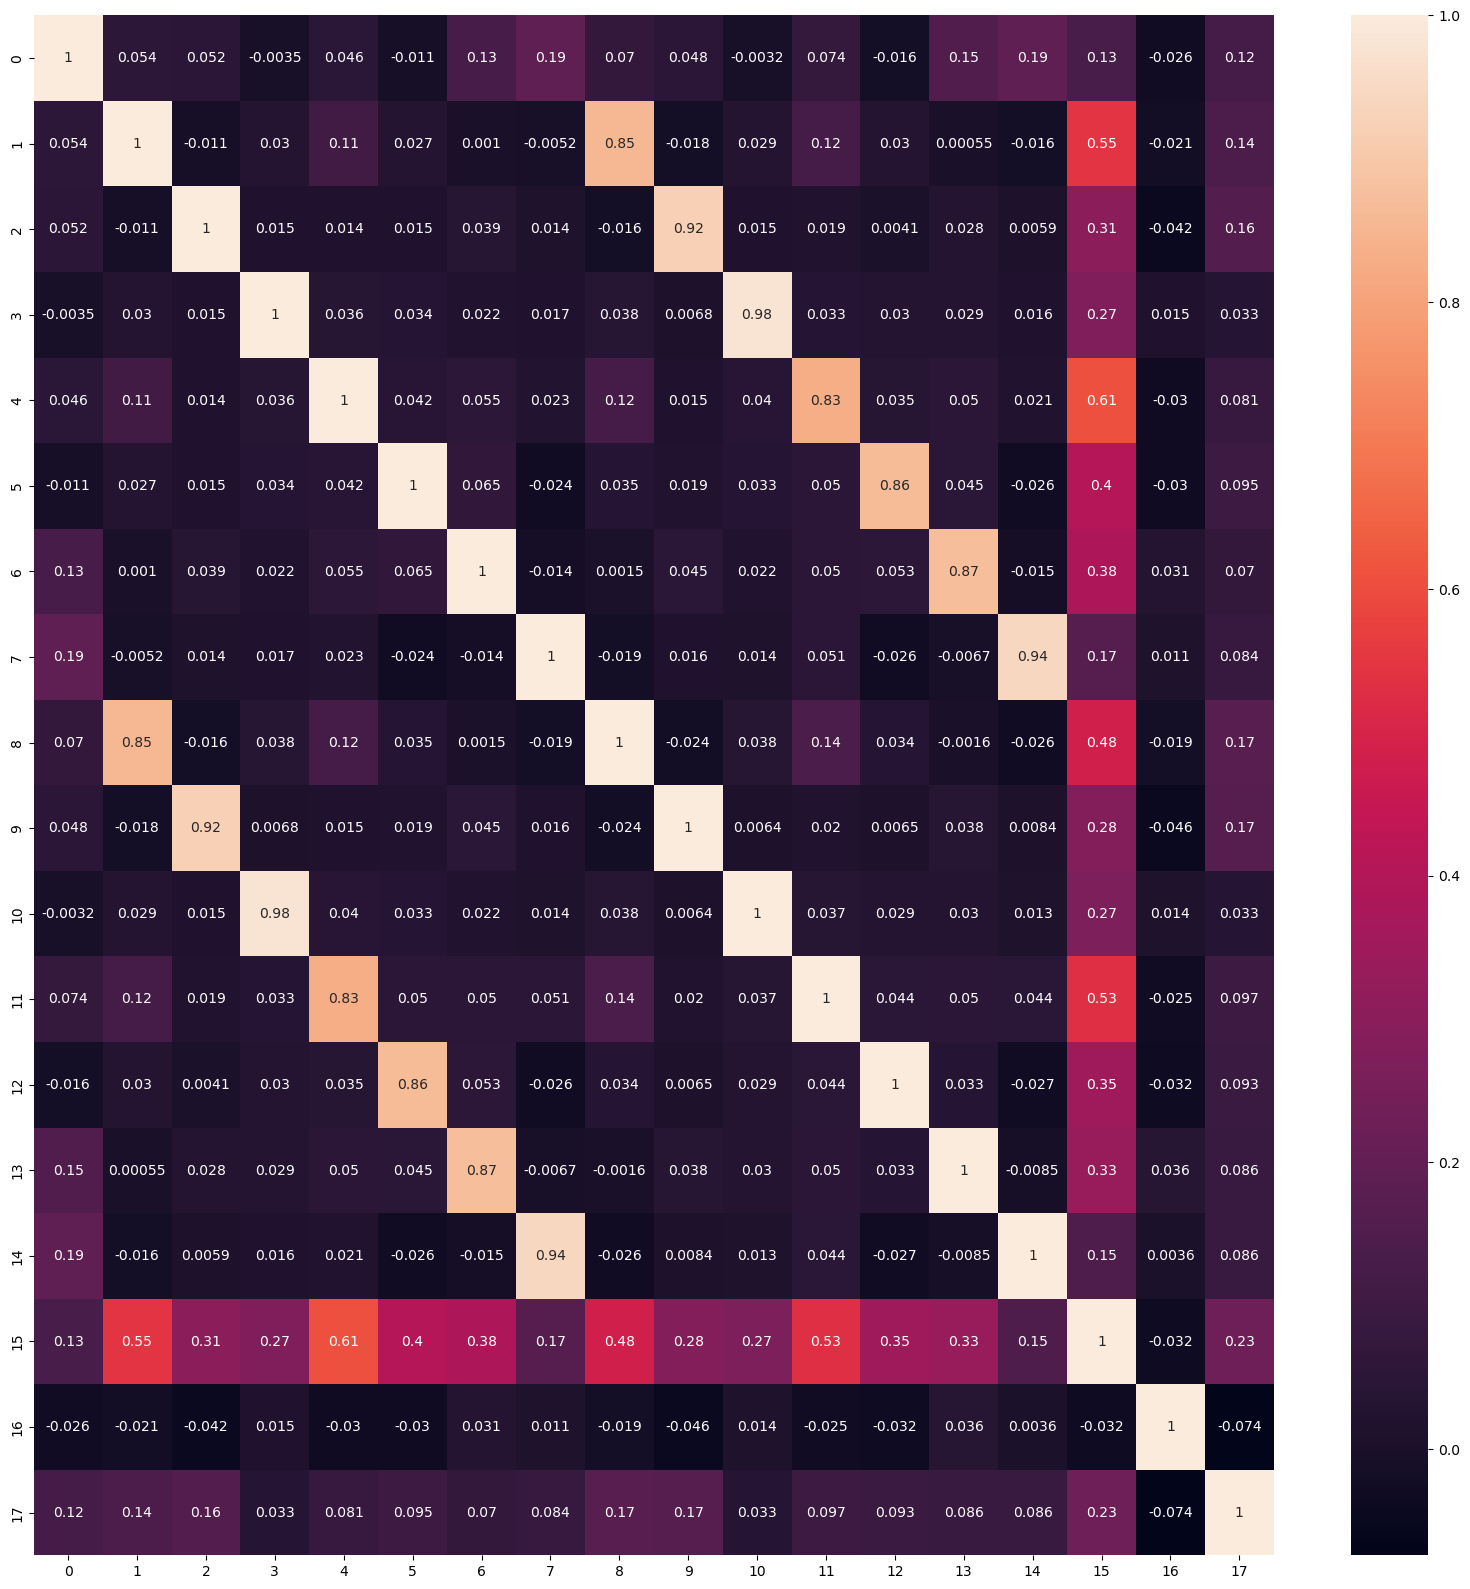

In [ ]:
# visualize the correlation between the features and the labels
import seaborn as sns
import matplotlib.pyplot as plt
# import numpy as np

# get the correlation matrix
corrMatrix = train_additional_features_tensor.numpy()
corrMatrix = np.concatenate((corrMatrix, train_label_tensor.numpy()), axis=1)
corrMatrix = pd.DataFrame(corrMatrix)
corrMatrix = corrMatrix.corr()

# plot the correlation matrix with figure size 12 by 12
plt.figure(figsize=(20,20))
sns.heatmap(corrMatrix, annot=True)

In [ ]:
# find the top 5 features that are correlated with the labels
corrMatrix.iloc[17,:].sort_values(ascending=False)[:6]


17    1.000000
15    0.230422
8     0.172631
9     0.166024
2     0.159868
1     0.143418
Name: 17, dtype: float64

In [ ]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# build a model of two hidden layers of 100 neurons each then one output layer to do the classification task 
# the input size is 17 and it's the train_additional_features_tensor

# define the model
class FinalMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(17, 786)
        self.fc2 = nn.Linear(786, 786)
        self.fc3 = nn.Linear(786, 786)
        self.fc4 = nn.Linear(786, 786)
        self.fc5 = nn.Linear(786, 1)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.fc5(x)
        x = self.sigmoid(x)
        return x
    
# initialize the model

model = FinalMLP()

# define the loss function
criterion = nn.BCELoss()
auc_loss_function =  torchmetrics.AUROC(task="binary")

# define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# define the number of epochs
epochs = 25

# define the batch size
batch_size = 256

# load data using data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# train the model

for epoch in range(epochs):
    running_loss = 0.0
    running_AUC = 0.0
    
    for i, data in enumerate(train_loader, 0):
        features, labels = data
        optimizer.zero_grad()
        outputs = model(features.float())
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_AUC += auc_loss_function(outputs, labels.float())

    
    # validate the model
    val_loss = 0.0
    val_auc = 0.0   
    for i, data in enumerate(val_loader, 0):
        features, labels = data
        outputs = model(features.float())
        loss = criterion(outputs, labels.float())
        val_loss += loss.item()
        val_auc += auc_loss_function(outputs, labels.float())


    # print the auc and loss for each epoch
    print('[%d] loss: %.3f, AUC: %.3f, val_loss: %.3f, val_AUC: %.3f' %
          (epoch + 1, running_loss / len(train_loader), running_AUC / len(train_loader), val_loss / len(val_loader), val_auc / len(val_loader)))



[1] loss: 0.663, AUC: 0.484, val_loss: 0.724, val_AUC: 0.560
[2] loss: 0.616, AUC: 0.658, val_loss: 0.770, val_AUC: 0.578
[3] loss: 0.614, AUC: 0.666, val_loss: 0.731, val_AUC: 0.578
[4] loss: 0.609, AUC: 0.669, val_loss: 0.746, val_AUC: 0.588
[5] loss: 0.605, AUC: 0.672, val_loss: 0.752, val_AUC: 0.572
[6] loss: 0.603, AUC: 0.674, val_loss: 0.766, val_AUC: 0.578
[7] loss: 0.608, AUC: 0.666, val_loss: 0.734, val_AUC: 0.587
[8] loss: 0.605, AUC: 0.669, val_loss: 0.762, val_AUC: 0.571
[9] loss: 0.604, AUC: 0.673, val_loss: 0.756, val_AUC: 0.597
[10] loss: 0.600, AUC: 0.677, val_loss: 0.758, val_AUC: 0.579
[11] loss: 0.603, AUC: 0.672, val_loss: 0.740, val_AUC: 0.575
[12] loss: 0.603, AUC: 0.673, val_loss: 0.772, val_AUC: 0.575
[13] loss: 0.604, AUC: 0.671, val_loss: 0.762, val_AUC: 0.564
[14] loss: 0.604, AUC: 0.671, val_loss: 0.760, val_AUC: 0.578
[15] loss: 0.602, AUC: 0.674, val_loss: 0.759, val_AUC: 0.573
[16] loss: 0.604, AUC: 0.676, val_loss: 0.761, val_AUC: 0.571
[17] loss: 0.604,